In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import normalize, MinMaxScaler

In [2]:
dftest1 = pd.read_csv("vh_vv_data_new_20.csv").drop("Unnamed: 0", axis =1)
dftest2 = pd.read_csv("vh_vv_data_new_20_100.csv").drop("Unnamed: 0", axis =1)
dftest3 = pd.read_csv("vh_vv_data_new_100_200.csv").drop("Unnamed: 0", axis =1)
dftest4 = pd.read_csv("vh_vv_data_new_200_225.csv").drop("Unnamed: 0", axis =1)
dftest5 = pd.read_csv("vh_vv_data_new_225_300.csv").drop("Unnamed: 0", axis =1)
dftest6 = pd.read_csv("vh_vv_data_new_300_350.csv").drop("Unnamed: 0", axis =1)
dftest7 = pd.read_csv("vh_vv_data_new_350_400.csv").drop("Unnamed: 0", axis =1)
dftest8 = pd.read_csv("vh_vv_data_new_400_450.csv").drop("Unnamed: 0", axis =1)
dftest9 = pd.read_csv("vh_vv_data_new_450_500.csv").drop("Unnamed: 0", axis =1)
dftest10 = pd.read_csv("vh_vv_data_new_500_557.csv").drop("Unnamed: 0", axis =1)
dftest = pd.concat([dftest1,dftest2,dftest3,dftest4, dftest5,dftest6, dftest7, dftest8, dftest9,dftest10])

### Prepare data

In [3]:
def clean_from_df_pad(string):
    """
    takes in each cell as a string and replaces it with an array of float value. 
    Also pads the sequence to length 26
    """
    splitted = string.split(" ")
    result = []
    for i in splitted:
        number = float(i.replace(",","").replace("[", "").replace("]", ""))
        result.append(number)
    if len(result) !=26:
        missing = 26-len(result)
        comp = [0] * missing
        result = result + comp
    return np.asarray(result)

In [4]:
# read in those dataframes again before this
dftest["vv_list"] = dftest.vv_list.apply(clean_from_df_pad)
dftest["vh_list"] = dftest.vh_list.apply(clean_from_df_pad)
dftest['vv/vh_list'] = dftest['vv/vh_list'].apply(clean_from_df_pad)

In [5]:
# add a climate index called rvi
def calculate_rvi(vv, vh):
    """
    takes in a list of vvs and a list of vhs, return a list of their rvis
    dop = vv/(vv+vh)
    m = 1-dop
    m = np.sqrt(m)
    power_func = 4*vh/(vv+vh)
    rvi = m*power_func
    """
    if len(vv)!= len(vh):
        return None
    else:
        rvi_lst = []
        for i in range(len(vv)):
            rvi = np.sqrt(1-vv[i]/(vv[i]+vh[i])) * 4*vh[i]/(vv[i]+vh[i])
            rvi_lst.append(rvi)
    return rvi_lst

calculate_rvi_func = np.vectorize(calculate_rvi)

In [6]:
dftest["rvi"] = calculate_rvi(list(dftest.vv_list), list(dftest.vh_list))

In [7]:
# length is equal
def df_to_arr_equal_len (df):
    """
    takes in a df, which will be data, and transforms it into a 3-d array with its original size
    """
    # loop through every row in df
    res = []
    for i in range(df.shape[0]):
        row = list(df.iloc[i,:]) # each row of df is turned into a list of three elements, where each element is an array
        new_row = [] # one day, one location, three variables
        for var in row:
            new_row.append(var)
        res.append(new_row)
    return np.asarray(res)

In [8]:
arr = df_to_arr_equal_len(dftest)
np.isnan(arr).sum()

2504

In [9]:
# replace null rvi's with 0
arr = np.nan_to_num(arr, nan=0)
np.isnan(arr).sum()

0

In [10]:
arr.shape

(557, 4, 26)

In [13]:
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:])
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(x, batch_size=50, shuffle=True)

In [14]:
x.shape

torch.Size([500, 4, 26])

In [15]:
y = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))

# use the first 500 samples to train
input = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
target = y[:500].float().view(500)

In [16]:
input.shape

torch.Size([500, 26, 4])

In [17]:
# create your dataset
training_dataset = MyDataset(input, target)

# create your dataloader
train_dataloader = DataLoader(training_dataset, batch_size=500, shuffle=True)

____
### Baseline LSTM with no batch norm
## NOTE: the following models are trained on the dataset with sequence length 26 (zero-padded)

In [21]:
# get gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [148]:
input = input.to(device)
target = target.to(device)

In [149]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, input):
        batch_size = input.size(0)
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_size).to(device)
        h0, c0 = h0.to(device), c0.to(device)
        lstm_out, _ = self.lstm(input, (h0, c0))
        output = self.linear(lstm_out[:, -1, :])
        return output

In [155]:
# Define hyperparameters
input_size = 4
hidden_size = 300
output_size = 1
num_layers = 5
num_epochs = 2000

# Create model and optimizer
LSTMmodel = MyLSTM(input_size, hidden_size, output_size, num_layers)
LSTMmodel.to(device)
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.05)
criterion = nn.L1Loss()
# Train model
input = input.to(device)
print_iters = 109
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output_seq = LSTMmodel(input)
    loss = criterion(output_seq.squeeze(), target)
    losses.append(loss.item())
    loss.backward()
    clip_grad_norm_(LSTMmodel.parameters(), max_norm = 1.0, norm_type=2, 
                        error_if_nonfinite=False)
    optimizer.step()
    if epoch % print_iters == print_iters - 1:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
print("Finished training")

Epoch [109/2000], Loss: 5859.8721
Epoch [218/2000], Loss: 5090.3970
Epoch [327/2000], Loss: 4321.4775
Epoch [436/2000], Loss: 3552.7463
Epoch [545/2000], Loss: 2784.1062
Epoch [654/2000], Loss: 2015.5182
Epoch [763/2000], Loss: 1249.1101
Epoch [872/2000], Loss: 764.5833
Epoch [981/2000], Loss: 673.8539
Epoch [1090/2000], Loss: 673.7704
Epoch [1199/2000], Loss: 673.7745
Epoch [1308/2000], Loss: 673.7689
Epoch [1417/2000], Loss: 673.7787
Epoch [1526/2000], Loss: 673.8041
Epoch [1635/2000], Loss: 673.7880
Epoch [1744/2000], Loss: 673.8109
Epoch [1853/2000], Loss: 673.7777
Epoch [1962/2000], Loss: 673.7953
Finished training


Baseline LSTM with no batch norm, hidden_size = 300, optimizer = Adam, lr = 0.05, num_layers=5


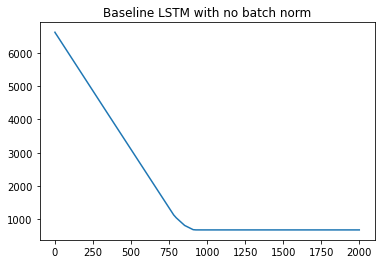

In [156]:
print("Baseline LSTM with no batch norm, hidden_size = 300, optimizer = Adam, lr = 0.05, num_layers=5")
plt.plot(range(len(losses)), losses)
plt.title("Baseline LSTM with no batch norm")
plt.show()

In [157]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = LSTMmodel(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(725.9503, device='cuda:0', grad_fn=<MeanBackward0>)


----
#### Improve this model by hyperparam tuning -- manual grid search

In [158]:
y = np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")["Rice Yield (kg/ha)"])

In [161]:
def train_LSTM_no_batch(hidden_size, num_layers, num_epochs, print_iters, optimizer_type, 
                        learning_rate, momentum):
    # Fixed hyperparams
    input_size = 4
    output_size = 1
    
    # Get data ready - use the first 500 samples to train
    input = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
    target = torch.from_numpy(y[:500]).float().view(500)
    input = input.to(device)
    target = target.to(device)
    
    # Create model and optimizer
    model = MyLSTM(input_size, hidden_size, output_size, num_layers)
    model.to(device)
    
    if optimizer_type =="Adam":
        momentum = None
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    if optimizer_type =="SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        
    criterion = nn.L1Loss()
    
    # Train model
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_seq = model(input)
        loss = criterion(output_seq.squeeze(), target)
        losses.append(loss.item())
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm = 1.0, norm_type=2, 
                        error_if_nonfinite=False)
        optimizer.step()
        if epoch % print_iters == print_iters - 1:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print("Finished training")
    return (model, losses)

In [163]:
mod1, losses1 = train_LSTM_no_batch(hidden_size=300, num_layers=8, num_epochs=2000, 
                                    print_iters=109, optimizer_type="SGD", 
                                    learning_rate=0.03, momentum=0.9)

Epoch [109/2000], Loss: 6244.2422
Epoch [218/2000], Loss: 5678.2231
Epoch [327/2000], Loss: 5110.9185
Epoch [436/2000], Loss: 4543.5981
Epoch [545/2000], Loss: 3976.2776
Epoch [654/2000], Loss: 3408.9495
Epoch [763/2000], Loss: 2841.6223
Epoch [872/2000], Loss: 2274.3015
Epoch [981/2000], Loss: 1706.9792
Epoch [1090/2000], Loss: 1143.2554
Epoch [1199/2000], Loss: 795.3702
Epoch [1308/2000], Loss: 674.0484
Epoch [1417/2000], Loss: 673.7767
Epoch [1526/2000], Loss: 673.7675
Epoch [1635/2000], Loss: 673.7902
Epoch [1744/2000], Loss: 673.7651
Epoch [1853/2000], Loss: 673.7719
Epoch [1962/2000], Loss: 673.7756
Finished training


In [165]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = mod1(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(725.9440, device='cuda:0', grad_fn=<MeanBackward0>)


Baseline LSTM with no batch norm, hidden_size=300, optimizer=SGD, lr=0.03, momemtum=0.9, num_layers=8


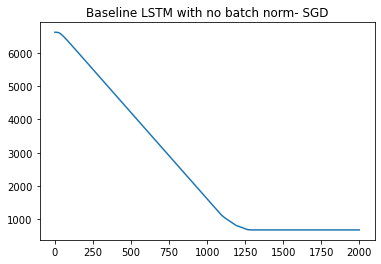

In [166]:
print("Baseline LSTM with no batch norm, hidden_size=300, optimizer=SGD, lr=0.03, momemtum=0.9, num_layers=8")
plt.plot(range(len(losses1)), losses1)
plt.title("Baseline LSTM with no batch norm- SGD")
plt.show()

----
#### Improve this model by using the scaled dataset

In [167]:
# normalize over each day (the last dimension)
for i in range(26):
    scaler = MinMaxScaler()
    arr[:,:,i] = scaler.fit_transform(arr[:,:,i])

In [169]:
mod2, losses2 = train_LSTM_no_batch(hidden_size=400, num_layers=6, num_epochs=1500, 
                                    print_iters=109, optimizer_type="SGD", 
                                    learning_rate=0.03, momentum=0.99)

Epoch [109/1500], Loss: 4862.6084
Epoch [218/1500], Loss: 675.8845
Epoch [327/1500], Loss: 889.8207
Epoch [436/1500], Loss: 739.4236
Epoch [545/1500], Loss: 719.4373
Epoch [654/1500], Loss: 684.6860
Epoch [763/1500], Loss: 675.9769
Epoch [872/1500], Loss: 676.2892
Epoch [981/1500], Loss: 674.8615
Epoch [1090/1500], Loss: 674.2227
Epoch [1199/1500], Loss: 673.9521
Epoch [1308/1500], Loss: 673.8034
Epoch [1417/1500], Loss: 673.7812
Finished training


In [170]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = mod2(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(725.9059, device='cuda:0', grad_fn=<MeanBackward0>)


Baseline LSTM with no batch norm, hidden_size=400, optimizer=SGD, lr=0.03, momemtum=0.99, num_layers=6


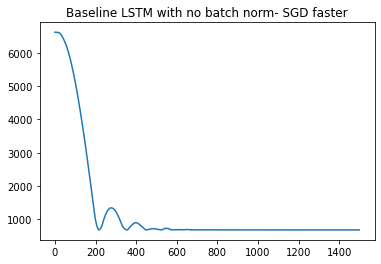

In [174]:
print("Baseline LSTM with no batch norm, hidden_size=400, optimizer=SGD, lr=0.03, momemtum=0.99, num_layers=6")
plt.plot(range(len(losses2)), losses2)
plt.title("Baseline LSTM with no batch norm- SGD faster")
plt.show()

____
### Add batch norm and dropout
### 1. batch_size = 100, dropout = 0.2, hidden_size = 100, num_layers= 5 (most underfit)

In [104]:
mod3, optimizer

(LSTMBN(
   (lstm): LSTM(4, 100, num_layers=5, batch_first=True, dropout=0.2)
   (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.5
     maximize: False
     momentum: 0.99
     nesterov: False
     weight_decay: 0
 ))

In [115]:
class LSTMBN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, dropout):
        super(LSTMBN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).requires_grad_()
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).requires_grad_()

        h0 = h0.to(device)
        c0 = c0.to(device)
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Apply batch normalization to output of LSTM
        out = out.transpose(1,2).contiguous()
        out = self.bn(out)
        out = out.transpose(1,2).contiguous()
        out = self.fc(out)
        return out

In [121]:
# prepare data -- make sure it's divided to batch
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500, 26, 4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=100, shuffle=True)

In [127]:
# Define hyperparameters -- can't change
input_size = 4
outout_size = 1

# can change
hidden_size = 100 
output_size = 1
criterion = nn.L1Loss()
num_layers = 5
batch_size = 100
num_epochs = 30

# Create the LSTM model
mod3 = LSTMBN(input_size, hidden_size, num_layers, batch_size, dropout = 0.2)
mod3.to(device)

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(mod3.parameters(), lr=0.1, momentum=0.9)

In [128]:
# Train the model
print_freq = 2
#best_val_loss = float('inf')
loss3 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mod3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # clip gradient to avoid exploding gradient
        #clip_grad_norm_(mod3.parameters(), max_norm = 0.1, norm_type="inf", error_if_nonfinite=False)
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    loss3.append(epoch_loss)
    if epoch% print_freq == 1:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print("Finished training")

Epoch [2/30], Loss: 6621.6212
Epoch [4/30], Loss: 6153.8747
Epoch [6/30], Loss: 2809.1214
Epoch [8/30], Loss: 1896.5248
Epoch [10/30], Loss: 1322.7846
Epoch [12/30], Loss: 871.5233
Epoch [14/30], Loss: 695.3644
Epoch [16/30], Loss: 722.0053
Epoch [18/30], Loss: 708.7775
Epoch [20/30], Loss: 688.8014
Epoch [22/30], Loss: 736.4419
Epoch [24/30], Loss: 857.0403
Epoch [26/30], Loss: 780.9605
Epoch [28/30], Loss: 830.5910


KeyboardInterrupt: 

In [130]:
# add more rounds of training with a differnt optimizer (smaller learning rate)
print_freq = 2
optimizer = torch.optim.Adam(mod3.parameters(), lr=0.03)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mod3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # clip gradient to avoid exploding gradient
        #clip_grad_norm_(mod3.parameters(), max_norm = 0.1, norm_type="inf", error_if_nonfinite=False)
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    loss3.append(epoch_loss)
    if epoch% print_freq == 1:
        print(f'Epoch [{epoch+1 +30}/{num_epochs+20}], Loss: {epoch_loss:.4f}')
print("Finished training")

Epoch [32/50], Loss: 682.9444
Epoch [34/50], Loss: 675.2162
Epoch [36/50], Loss: 674.1320
Epoch [40/50], Loss: 674.1635
Epoch [42/50], Loss: 674.4898
Epoch [44/50], Loss: 674.0641
Epoch [46/50], Loss: 674.0472


KeyboardInterrupt: 

LSTM with batch_size=100, hidden_size=100, optimizer=SGD, lr=0.5, momemtum=0.99, num_layers=5, dropout=0.2


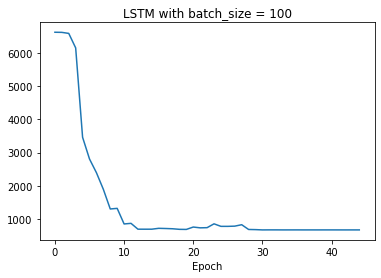

In [148]:
print("LSTM with batch_size=100, hidden_size=100, optimizer=SGD, lr=0.5, momemtum=0.99, num_layers=5, dropout=0.2")
plt.plot(range(len(loss3)), loss3)
plt.xlabel("Epoch")
plt.title("LSTM with batch_size = 100")
plt.show()

In [134]:
# testing results
print("Last error in training loss: ", loss3[-1])
x = torch.from_numpy(arr[457:,:,:]).float().view(100,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[457:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
#test_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0

inputs, targets = x.to(device), y.to(device)
outputs = mod3(inputs)
loss = criterion(outputs, targets)
print("\nSince 57 testing samples is not enough for batch size 100, leaked some of training samples into testing.\nTesting error: ", loss.item())

Last error in training loss:  674.1071411132813

Since 57 testing samples is not enough for batch size 100, leaked some of training samples into testing.
Testing error:  723.1863403320312


### 2. Less underfit: batch_size = 50, num_layers = 5, hidden_size = 200, dropout=0.1
#### Since lr was too slow last time, change to Adam

In [135]:
# prepare data -- make sure it's divided to batch
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500, 26, 4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

In [136]:
# Define hyperparameters -- can't change
input_size = 4
outout_size = 1

# can change
hidden_size = 200 
criterion = nn.L1Loss()
num_layers = 5
batch_size = 50
num_epochs = 20

# Create the LSTM model
mod4 = LSTMBN(input_size, hidden_size, num_layers, batch_size, dropout = 0.1)
mod4.to(device)

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(mod4.parameters(), lr=0.05)

In [137]:
# Train the model
print_freq = 2
loss4 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mod4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # clip gradient to avoid exploding gradient
        #clip_grad_norm_(mod3.parameters(), max_norm = 0.1, norm_type="inf", error_if_nonfinite=False)
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    loss4.append(epoch_loss)
    if epoch% print_freq == 1:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print("Finished training")

Epoch [2/20], Loss: 6525.9172
Epoch [4/20], Loss: 5901.2949
Epoch [6/20], Loss: 4439.6146
Epoch [8/20], Loss: 1963.4461
Epoch [10/20], Loss: 771.0478
Epoch [12/20], Loss: 679.8991
Epoch [14/20], Loss: 675.6930
Epoch [16/20], Loss: 674.8898
Epoch [18/20], Loss: 675.0321


KeyboardInterrupt: 

LSTM with batch_size=50, hidden_size=200, optimizer=Adam, lr=0.05, num_layers=5, dropout=0.1


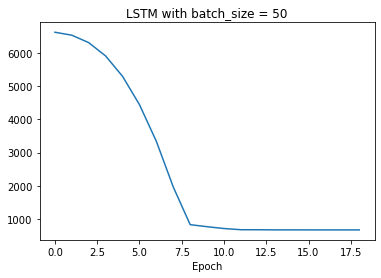

In [138]:
print("LSTM with batch_size=50, hidden_size=200, optimizer=Adam, lr=0.05, num_layers=5, dropout=0.1")
plt.plot(range(len(loss4)), loss4)
plt.xlabel("Epoch")
plt.title("LSTM with batch_size = 50")
plt.show()

In [147]:
# testing results
print("Last error in training loss: ", loss4[-1])

print("\nSince 57 testing samples is not enough for batch size 100, leaked some of training samples into testing to get two batches.\n")
      
x = torch.from_numpy(arr[457:,:,:]).float().view(100,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[457:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(testing_dataset, batch_size=50, shuffle=True)

# Evaluate the model on the test dataset -- leaked some points to get two batches
total_loss = 0.0

for i , data in enumerate(test_dataloader):
    inputs, targets = data[0].to(device), data[1].to(device)
    outputs = mod4(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print("Testing error: ", total_loss/ len(test_dataloader))

Last error in training loss:  674.3980529785156

Since 57 testing samples is not enough for batch size 100, leaked some of training samples into testing to get two batches.

Testing error:  720.1632080078125


### 3. Even smaller batch --- batch_size = 20, num_layers = 10, hidden_size = 100, dropout = 0
#### Use Adam optimizer

In [152]:
# prepare data -- make sure it's divided to batch
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500, 26, 4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=20, shuffle=True)

In [153]:
# Define hyperparameters 
hidden_size = 100 
num_layers = 10
batch_size = 20
num_epochs = 20

# Create the LSTM model
mod5 = LSTMBN(input_size, hidden_size, num_layers, batch_size, dropout=0)
mod5.to(device)

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(mod5.parameters(), lr=0.05)

In [154]:
# Train the model
print_freq = 2
loss5 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mod5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    loss5.append(epoch_loss)
    if epoch% print_freq == 1:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print("Finished training")

KeyboardInterrupt: 

In [ ]:
print("LSTM with batch_size=20, hidden_size=100, optimizer=Adam, lr=0.05, num_layers=10, dropout=0")
plt.plot(range(len(loss5)), loss5)
plt.xlabel("Epoch")
plt.title("LSTM with batch_size = 20")
plt.show()

In [ ]:
# testing results
print("Last error in training loss: ", loss5[-1])

print("\nSince 57 testing samples is not enough for batch size 20, leaked some of training samples into testing to get three batches.\n")
      
x = torch.from_numpy(arr[497:,:,:]).float().view(60,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[497:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(testing_dataset, batch_size=20, shuffle=True)

# Evaluate the model on the test dataset -- leaked some points to get two batches
total_loss = 0.0
for i , data in enumerate(test_dataloader):
    inputs, targets = data[0].to(device), data[1].to(device)
    outputs = mod5(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print("Testing error: ", total_loss/ len(test_dataloader))

-----
-----
#### *Helper functions - run these first before training any model*

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

**Getting a NaN loss during training of an LSTM model in PyTorch usually indicates a numerical instability in the optimization process. It can occur due to several reasons, such as:**

- Exploding gradients: In LSTM models, gradients can become too large, causing the weights to update with excessively large values. This can make the model unstable and lead to NaN losses.
- Vanishing gradients: The opposite of exploding gradients, when the gradients become too small and can’t update the weights effectively, leading to stagnation of the training process.
- Too high learning rate: A high learning rate can cause the optimization process to overshoot the optimal solution and lead to divergence.
- Numerical precision: Some operations in PyTorch can be numerically unstable, especially when working with very large or very small numbers. This can lead to NaN losses if not handled properly.

**To fix this issue, you can try the following steps:**
- Clip the gradients: To prevent exploding gradients, you can clip the gradients to a maximum norm value.
- ***Use gradient regularization: Regularization techniques such as weight decay, dropout, and batch normalization can help prevent overfitting and reduce the risk of numerical instability.***
- Check the input data: Make sure that the input data does not contain NaN or Inf values.
- Decrease the learning rate: If the learning rate is too high, try decreasing it to prevent overshooting.
- Use higher precision: You can try using higher precision data types such as float64 to reduce the risk of numerical instability.
- Debugging: You can use debugging techniques such as printing the intermediate results of your model and checking the data types of your inputs and outputs.